# Import required libraries

In [324]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.tree import export_text
from sklearn.metrics import root_mean_squared_error, r2_score
import xgboost as xgb 
%matplotlib inline

## Exploratory Data Analysis  

In [325]:
df = pd.read_csv('../datasets/Netflix_stock_history.csv', parse_dates=["Date"]) # Load dataset with date parsing - Converts 'Date' column to datetime instead of string
df.columns = df.columns.str.lower().str.replace(' ', '_')
# Display basic dataset information
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4870 entries, 0 to 4869
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          4870 non-null   datetime64[ns]
 1   open          4870 non-null   float64       
 2   high          4870 non-null   float64       
 3   low           4870 non-null   float64       
 4   close         4870 non-null   float64       
 5   volume        4870 non-null   int64         
 6   dividends     4870 non-null   int64         
 7   stock_splits  4870 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 304.5 KB


In [326]:
# Display the first few rows
print("First 5 Rows:")
print(df.head())

First 5 Rows:
        date      open      high       low     close     volume  dividends  \
0 2002-05-23  1.156429  1.242857  1.145714  1.196429  104790000          0   
1 2002-05-24  1.214286  1.225000  1.197143  1.210000   11104800          0   
2 2002-05-28  1.213571  1.232143  1.157143  1.157143    6609400          0   
3 2002-05-29  1.164286  1.164286  1.085714  1.103571    6757800          0   
4 2002-05-30  1.107857  1.107857  1.071429  1.071429   10154200          0   

   stock_splits  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  


In [327]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
# Summary statistics of stock prices
print("Statistic Values:")
df.describe()

Missing Values:
date            0
open            0
high            0
low             0
close           0
volume          0
dividends       0
stock_splits    0
dtype: int64
Statistic Values:


,date,open,high,low,close,volume,dividends,stock_splits
count,4870,4870.000000,4870.000000,4870.000000,4870.000000,4.870000e+03,4870.0,4870.000000
mean,2012-01-23 12:36:57.659137792,104.243285,105.833669,102.608072,104.282593,1.682662e+07,0.0,0.001848
min,2002-05-23 00:00:00,0.377857,0.410714,0.346429,0.372857,2.856000e+05,0.0,0.000000
25%,2007-03-26 06:00:00,3.898214,3.975000,3.833214,3.902500,6.309850e+06,0.0,0.000000
50%,2012-01-23 12:00:00,21.144286,21.406429,20.743572,21.004285,1.085175e+07,0.0,0.000000
75%,2016-11-21 18:00:00,124.975002,126.427502,122.847502,124.797503,2.018555e+07,0.0,0.000000
max,2021-09-24 00:00:00,606.469971,615.599976,596.549988,606.710022,3.234140e+08,0.0,7.000000
std,NaN,155.319234,157.589034,152.978074,155.365529,1.938116e+07,0.0,0.104316


In [328]:
df['dividends'].unique()

array([0])

In [329]:
# Drop 'Dividends' since all are 0s
df = df.drop('dividends', axis=1)

## OHLCV

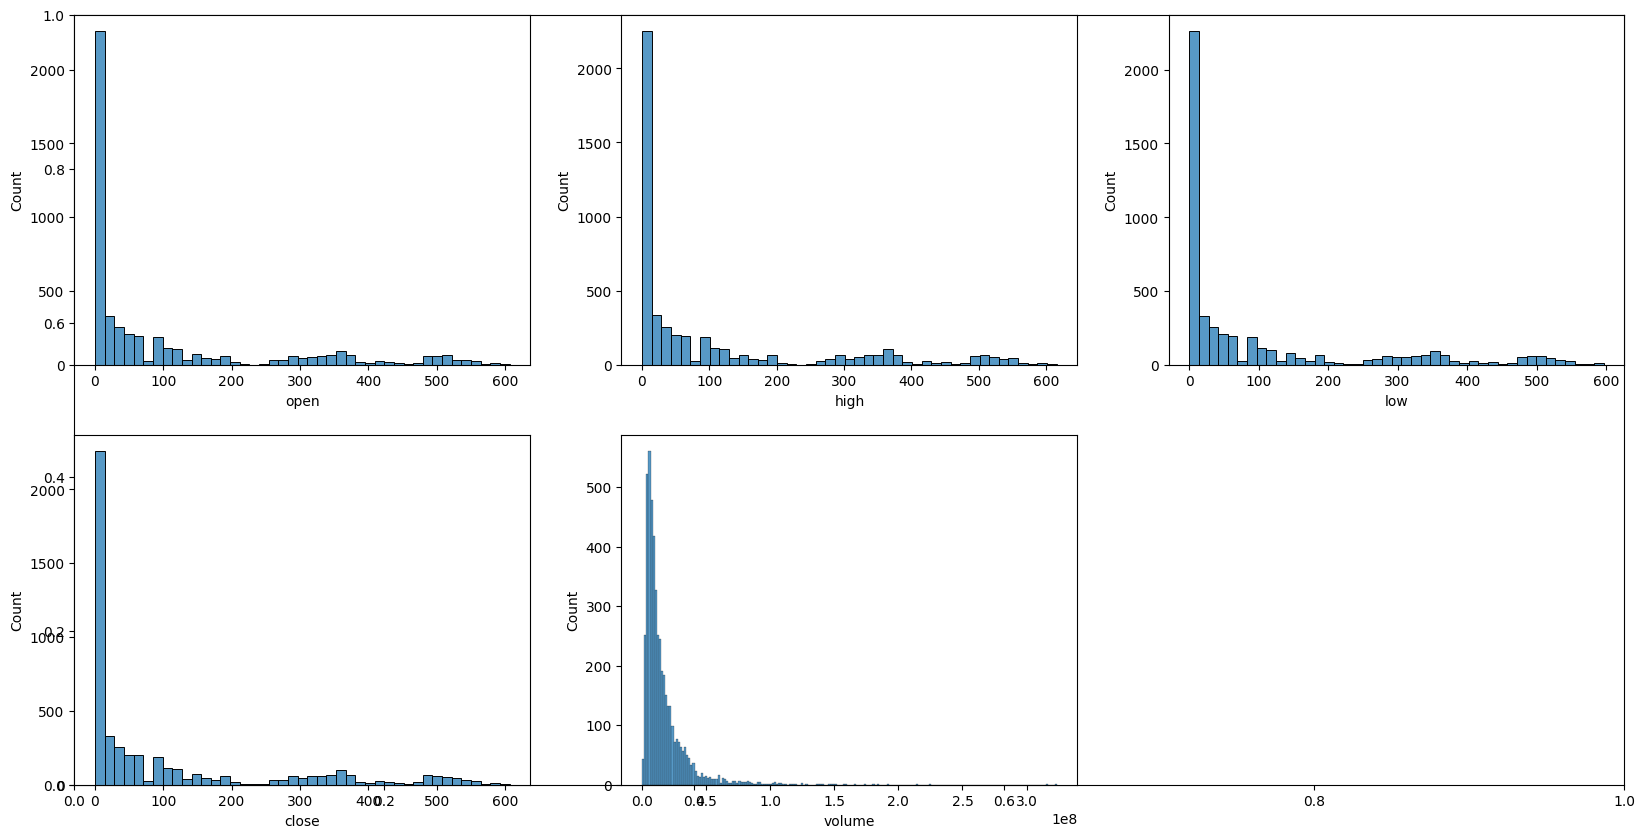

In [330]:
features = ['open', 'high', 'low', 'close', 'volume']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
  plt.subplot(2, 3 , i+1)
  sns.histplot(df[col])
plt.show()

## Stock Price Trends Over Time

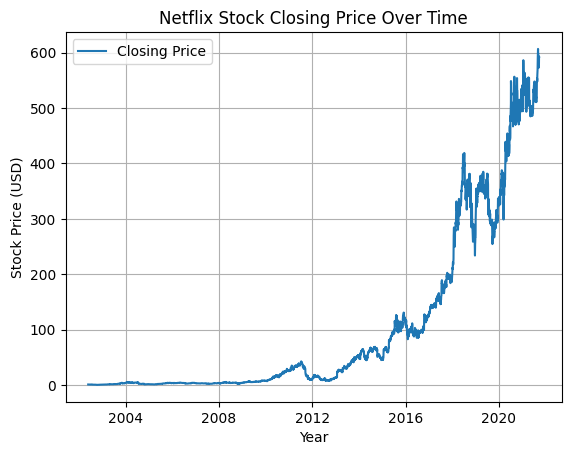

In [331]:
plt.plot(df["date"],df["close"], label="Closing Price")
plt.xlabel("Year")
plt.ylabel("Stock Price (USD)")
plt.title("Netflix Stock Closing Price Over Time")
plt.legend()
plt.grid(True)
plt.show()

## Trading Volume Trends

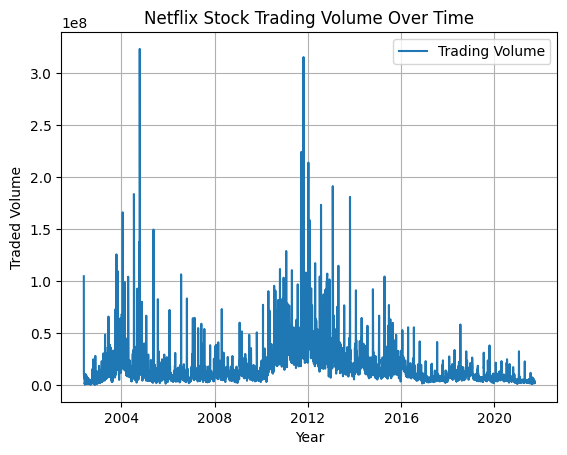

In [332]:
plt.plot(df["date"], df["volume"], label="Trading Volume")
plt.xlabel("Year")
plt.ylabel("Traded Volume")
plt.title("Netflix Stock Trading Volume Over Time")
plt.legend()
plt.grid(True)
plt.show()

## Stock Price with Splits

In [333]:
df_splits = df[df["stock_splits"] > 0]

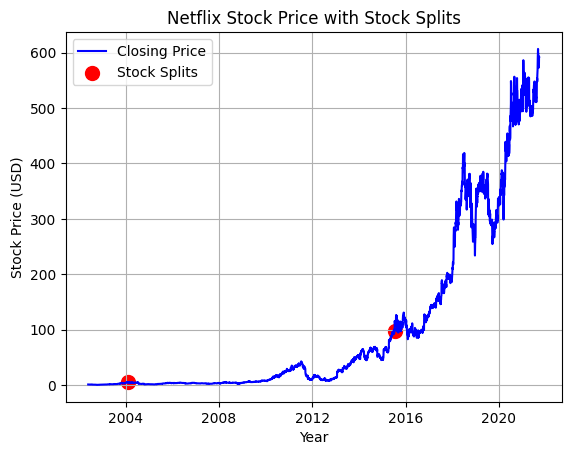

In [334]:
plt.plot(df["date"], df["close"], label="Closing Price", color="blue")
plt.scatter(df_splits["date"], df_splits["close"], color="red", label="Stock Splits", marker="o",s=100)
plt.xlabel("Year")
plt.ylabel("Stock Price (USD)")
plt.title("Netflix Stock Price with Stock Splits")
plt.legend()
plt.grid(True)
plt.show()

# Feature Engineering

In [335]:
def add_basic_time_features(df):
    df = df.copy()
    df['day'] = df['date'].dt.day
    df['dow'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_quarter_end'] = np.where(df['month'] % 3 == 0, 1, 0)
    df['is_year_end'] = df['date'].dt.is_year_end.astype(int)
    return df

def add_return_and_lags(df, cols=['close'], lags=[1,2,3,5,10]):
    df = df.copy()
    for c in cols:
        df[f'{c}_ret'] = df[c].pct_change()
        df[f'{c}_logret'] = np.log(df[c]) - np.log(df[c].shift(1))
        for l in lags:
            df[f'{c}_lag{l}'] = df[c].shift(l)
            df[f'{c}_ret_l{l}'] = df[f'{c}_ret'].shift(l)
    return df

def add_rolling_stats(df, col='close', windows=[5,10,20,50,200]):
    df = df.copy()
    for w in windows:
        df[f'{col}_sma{w}'] = ta.sma(df[col], length=w)
        df[f'{col}_std{w}'] = df[col].rolling(window=w, min_periods=1).std()
        df[f'{col}_min{w}'] = df[col].rolling(window=w, min_periods=1).min()
        df[f'{col}_max{w}'] = df[col].rolling(window=w, min_periods=1).max()
        df[f'{col}_ma_diff{w}'] = df[col] - df[f'{col}_sma{w}']
    return df

def add_bollinger(df, window=20):
    df = df.copy()

    bb_result = ta.bbands(df['close'], length=window, std=2)
    df = df.join(bb_result)
     
    return df

def add_volume_features(df):
    df = df.copy()
    df['vol_change'] = df['volume'].pct_change()
    df['vol_ma20'] = ta.sma(df['volume'], length=20)
    
    # OBV using pandas_ta
    obv_result = ta.obv(df['close'], df['volume'])
    df['obv'] = obv_result
    
    return df

# Apply all feature engineering functions
df = df.sort_values('date').reset_index(drop=True)
df = add_basic_time_features(df)
df = add_return_and_lags(df, cols=['close','open','high','low'], lags=[1,2,3,5])
df = add_rolling_stats(df, 'close', windows=[5,10,20,50,200])
df = add_bollinger(df, window=20)
df = add_volume_features(df)

# Drop rows with any NaN in feature columns
df = df.dropna()  

# Create target: next-day return 
# Formula: (tomorrow_close / today_close) - 1
# Predicts exact return percentage for next day
df['target_1d_return'] = df['close'].shift(-1) / df['close'] - 1

# Creates a binary classification target based on next-day return
# 1: next-day return > 0 (price goes up)
# 0: next-day return <= 0 (flat or down)
df['target_direction'] = (df['target_1d_return'] > 0).astype(int)

# Drop rows with NaN in target column
df = df.dropna(subset=['target_1d_return'])  

print("DataFrame shape after feature engineering:", df.shape)
df.columns = df.columns.str.lower()
print("Columns:", df.columns)

DataFrame shape after feature engineering: (4670, 90)
Columns: Index(['date', 'open', 'high', 'low', 'close', 'volume', 'stock_splits', 'day',
       'dow', 'month', 'year', 'is_month_end', 'is_month_start',
       'is_quarter_end', 'is_year_end', 'close_ret', 'close_logret',
       'close_lag1', 'close_ret_l1', 'close_lag2', 'close_ret_l2',
       'close_lag3', 'close_ret_l3', 'close_lag5', 'close_ret_l5', 'open_ret',
       'open_logret', 'open_lag1', 'open_ret_l1', 'open_lag2', 'open_ret_l2',
       'open_lag3', 'open_ret_l3', 'open_lag5', 'open_ret_l5', 'high_ret',
       'high_logret', 'high_lag1', 'high_ret_l1', 'high_lag2', 'high_ret_l2',
       'high_lag3', 'high_ret_l3', 'high_lag5', 'high_ret_l5', 'low_ret',
       'low_logret', 'low_lag1', 'low_ret_l1', 'low_lag2', 'low_ret_l2',
       'low_lag3', 'low_ret_l3', 'low_lag5', 'low_ret_l5', 'close_sma5',
       'close_std5', 'close_min5', 'close_max5', 'close_ma_diff5',
       'close_sma10', 'close_std10', 'close_min10', 'close_

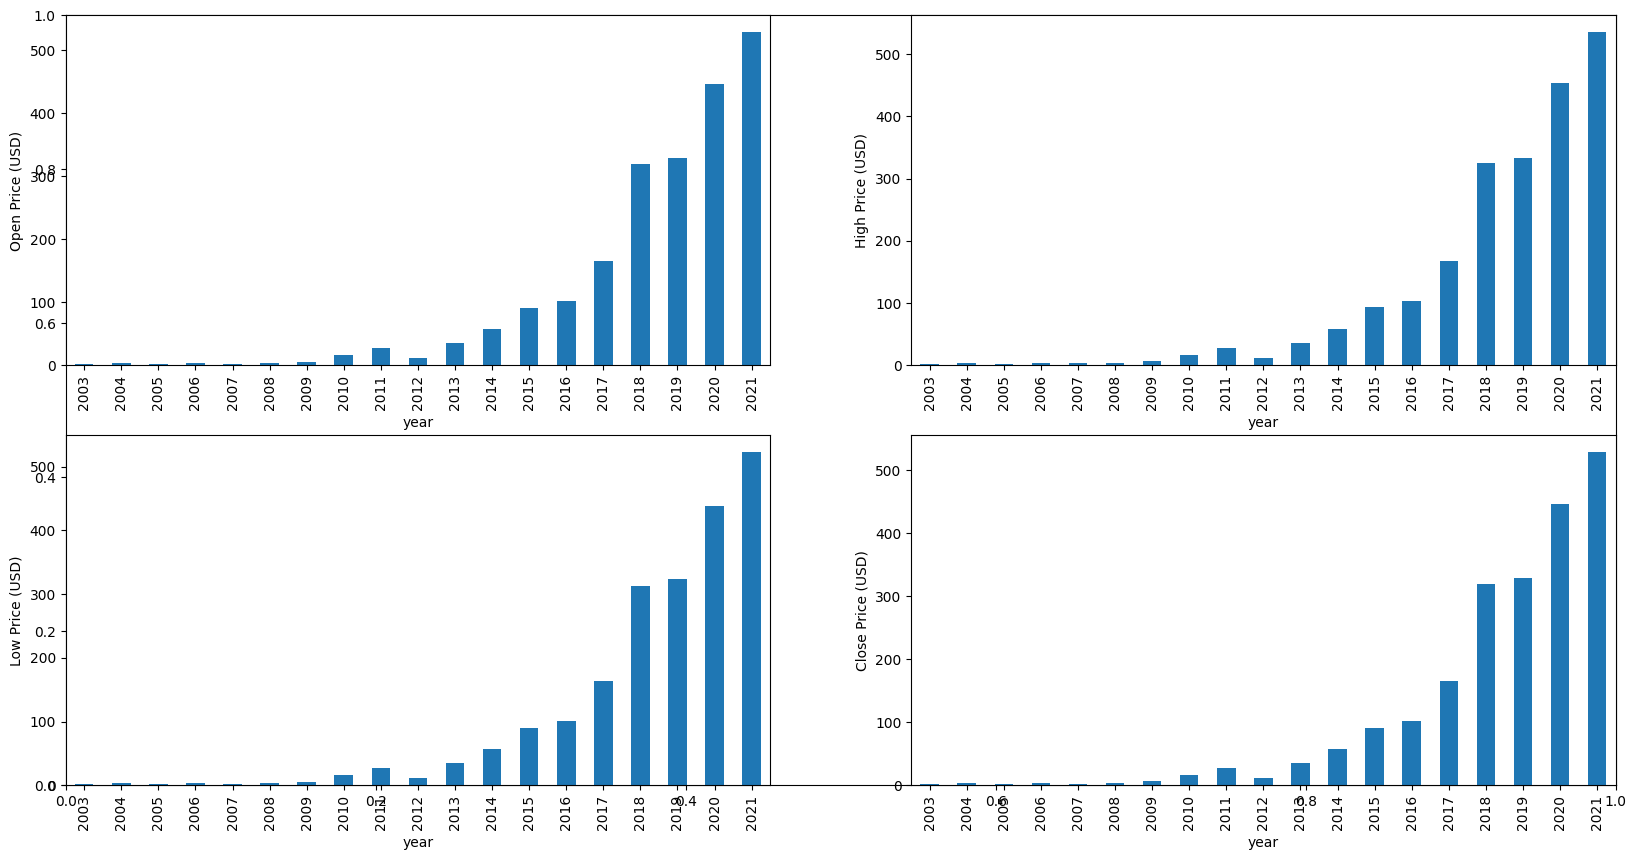

In [336]:
data_grouped = df.drop('date', axis=1).groupby('year').mean()
plt.subplots(figsize=(20,10))

for i, col in enumerate(['open', 'high', 'low', 'close']):
  plt.subplot(2,2,i+1)
  plt.ylabel(col.capitalize() + ' Price (USD)')
  data_grouped[col].plot.bar()
plt.show()

From the above bar graph, we can conclude that the stock prices have doubled from the year 2017 to that in 2018.

# Bollinger bands

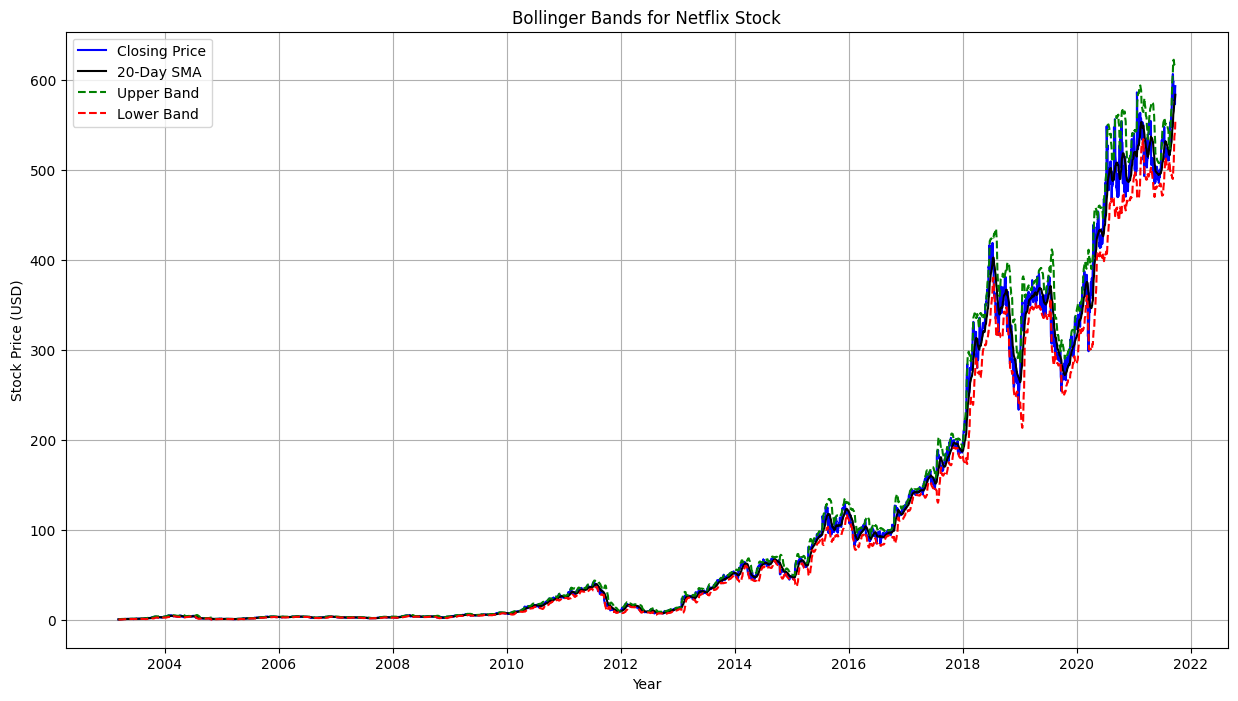

In [337]:
plt.figure(figsize=(15, 8))
plt.plot(df["date"], df["close"], label="Closing Price", color="blue")
plt.plot(df["date"], df["close_sma20"], label="20-Day SMA", color="black")
plt.plot(df["date"], df["bbu_20_2.0_2.0"], label="Upper Band",color="green",linestyle='--')
plt.plot(df["date"], df["bbl_20_2.0_2.0"], label="Lower Band",color="red",linestyle='--')
plt.xlabel("Year")
plt.ylabel("Stock Price (USD)")
plt.title("Bollinger Bands for Netflix Stock")
plt.legend()
plt.grid(True)
plt.show()

In [338]:
df.head()

,date,open,high,low,close,volume,stock_splits,day,dow,month,...,bbl_20_2.0_2.0,bbm_20_2.0_2.0,bbu_20_2.0_2.0,bbb_20_2.0_2.0,bbp_20_2.0_2.0,vol_change,vol_ma20,obv,target_1d_return,target_direction
199,2003-03-10,1.141429,1.164286,1.122143,1.123571,3424400,0.0,10,0,3,...,0.882380,1.070357,1.258334,35.124101,0.641544,-0.294491,7433020.0,3827600.0,-0.014621,0
200,2003-03-11,1.123571,1.125000,1.071429,1.107143,5531400,0.0,11,1,3,...,0.912854,1.081179,1.249503,31.137152,0.577126,0.615290,7344330.0,-1703800.0,-0.028388,0
201,2003-03-12,1.103571,1.107857,1.064286,1.075714,5751200,0.0,12,2,3,...,0.936582,1.088607,1.240633,27.930300,0.457595,0.039737,7392350.0,-7455000.0,0.079017,1
202,2003-03-13,1.097143,1.183571,1.089286,1.160714,7560000,0.0,13,3,3,...,0.959199,1.099214,1.239229,25.475483,0.719618,0.314508,7489580.0,105000.0,0.018462,1
203,2003-03-14,1.185714,1.210714,1.170714,1.182143,6129200,0.0,14,4,3,...,0.986997,1.111107,1.235217,22.339879,0.786181,-0.189259,7491400.0,6234200.0,0.087613,1


# Split the dataset

In [339]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)  
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['target_direction'].values
y_val = df_val['target_direction'].values
y_test = df_test['target_direction'].values

del df_train['target_direction']
del df_val['target_direction']
del df_test['target_direction']


In [340]:
df_full_train.shape,df_train.shape,df_val.shape,df_test.shape

((3736, 90), (2802, 89), (934, 89), (934, 89))